This file will be the model in itself, in it we will split the data, pre-process it and then use a model to predict prices in the test data

# Pre-process

In [568]:
import os
import warnings
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [569]:
# The first step is that we have to split the data correctly
df_final = pd.read_csv("ready_to_learn_csv.csv")

y = df_final["Price"]
X = df_final.drop(["Price"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, test_size=0.2, shuffle=True
)

In [570]:
def ordinal_encoding():
    """
    change the categorical value with the ordinal encoding method
    """
    global X_train
    global X_test

    X_train = X_train.replace(
        {
            "State_of_the_building": {
                "AS_NEW": 6,
                "JUST_RENOVATED": 5,
                "GOOD": 4,
                "TO_BE_DONE_UP": 3,
                "TO_RENOVATE": 2,
                "TO_RESTORE": 1,
            }
        }
    )  # check meaning of these
    X_test = X_test.replace(
        {
            "State_of_the_building": {
                "AS_NEW": 6,
                "JUST_RENOVATED": 5,
                "GOOD": 4,
                "TO_BE_DONE_UP": 3,
                "TO_RENOVATE": 2,
                "TO_RESTORE": 1,
            }
        }
    )

In [571]:
def get_median_price_per_sm():
    """
    For each localities in the X_train part, this function will compute the median price per square meter,
    then it will merge these values with X_train and X_test and will delete the collumn locality
    """
    global X_train
    global X_test

    # creation of a new dataframe, containing locality and median price per square meter of the locality (on X_train)
    area = X_train["Living_Area"] + df_final["Terrace_Area"] + df_final["Garden_Area"]
    X_train["Price_Squared_Meter"] = df_final["Price"] / area
    median_price_meter = X_train.groupby("Locality")["Price_Squared_Meter"].median()
    X_train.drop(["Price_Squared_Meter"], axis=1, inplace=True)

    # merge this new df with x_train and x_test
    X_train = X_train.merge(median_price_meter, how="left", on="Locality")
    X_test = X_test.merge(median_price_meter, how="left", on="Locality")
    # print(X_train["Price_Squared_Meter"])

    # delete Locality collumn (no more use)
    X_train.drop(["Locality"], axis=1, inplace=True)
    X_test.drop(["Locality"], axis=1, inplace=True)

In [572]:
def missing_values():
    """
    this function will deal with missing values, for the needed columns it adds a new column_wasmissing,
    and 'replace' the missing values with the help of a simple imputer
    """
    global X_train
    global X_test
    cols_with_missing = X_test.columns[
        (X_train.isna() | X_test.isna()).any().values
    ].tolist()
    for col in cols_with_missing:
        X_train[col + "_was_missing"] = X_train[col].isnull()
        X_test[col + "_was_missing"] = X_test[col].isnull()

    my_imputer = SimpleImputer()
    imputed_X_train = pd.DataFrame(my_imputer.fit_transform(X_train))
    imputed_X_test = pd.DataFrame(my_imputer.transform(X_test))
    # Imputation removed column names; put them back
    imputed_X_train.columns = X_train.columns
    imputed_X_test.columns = X_test.columns

    X_train = imputed_X_train
    X_test = imputed_X_test
    # test----------------  we only keep locality which were in the training data--------------------------------------------------------------------------------------
    """
    X_test= X_test.reset_index(drop=True)
    mask = X_test['Price_Squared_Meter_was_missing'] < 1
    X_test = X_test[mask]
    global y_test
    y_test = y_test.iloc[mask.index[mask]] 
    """

In [573]:
def normalize():
    """
    this function normalize each columns for X_train and X_test
    """
    global X_train
    global X_test
    for column in X_train.columns:
        # Get mean and standard deviation from training set (per feature)
        min = np.min(X_train[column])
        max = np.max(X_train[column])
        if min == max:
            continue

        # Standardize training and testing set using the mean and standard deviation from the training set
        X_train[column] = (X_train[column] - min) / (max - min)
        X_test[column] = (X_test[column] - min) / (max - min)

In [574]:
def standardize():
    """
    This function standardize each columns for X_train and X_test
    """
    global X_train
    global X_test
    for column in X_train.columns:
        # Get mean and standard deviation from training set (per feature)
        mean = np.mean(X_train[column])
        stdev = np.std(X_train[column])
        if stdev == 0:
            continue

        # Standardize training and testing set using the mean and standard deviation from the training set
        X_train[column] = (X_train[column] - mean) / stdev
        X_test[column] = (X_test[column] - mean) / stdev

In [575]:
def preprocess():
    """
    this function will preprocess the data, it deals with nan values, non numerical values and normalize the columns
    """
    global X_train
    global X_test

    # deal with categorical variables----------------------------------------------------------------------------------------------------------------------------------------------------
    # one hot encoding
    X_train = pd.get_dummies(
        X_train, columns=["Type_of_property", "Subtype_of_property"], drop_first=True
    )
    X_test = pd.get_dummies(
        X_test, columns=["Type_of_property", "Subtype_of_property"], drop_first=True
    )
    # one hot encoding is necessary for some model, useless for others, using XGBoost I wont'y use get_dumies (see odel opti)

    # ordinal encoding
    ordinal_encoding()

    # locality is an int but we consider it as a categorical variabe, we will replace this column by the median price per square meter for each different localities
    get_median_price_per_sm()

    # deal with missing values---------------------------------------------------------------------------------------------------------------------------------------------------------------
    missing_values()

    # standardize----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    standardize()
    # normalize()

    # resampling-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    # todo???

In [576]:
preprocess()
# X_test.to_csv('test.csv', index = False)

# Prediction

In [577]:
"""
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(random_state=0, n_estimators=300, max_depth=5)
model.fit(X_train, y_train)
preds = model.predict(X_test)
print("mean absolute error", mean_absolute_error(y_test, preds))

score = model.score(X_train, y_train)
print("Evaluating the model on the training set yields an accuracy of {}%".format(score*100))
score=model.score(X_test, y_test)
print("Evaluating the model on the testing set yields an accuracy of {:.2f}%".format(score*100))
"""

'\nfrom sklearn.ensemble import GradientBoostingRegressor\n\nmodel = GradientBoostingRegressor(random_state=0, n_estimators=300, max_depth=5)\nmodel.fit(X_train, y_train)\npreds = model.predict(X_test)\nprint("mean absolute error", mean_absolute_error(y_test, preds))\n\nscore = model.score(X_train, y_train)\nprint("Evaluating the model on the training set yields an accuracy of {}%".format(score*100))\nscore=model.score(X_test, y_test)\nprint("Evaluating the model on the testing set yields an accuracy of {:.2f}%".format(score*100))\n'

In [578]:
"""
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=5, random_state=0)
model.fit(X_train, y_train)
preds = model.predict(X_test)
print("mean absolute error", mean_absolute_error(y_test, preds))

#r-squared error
score = model.score(X_train, y_train)
print("Evaluating the model on the training set yields an accuracy of {}%".format(score*100))
score=model.score(X_test, y_test)
print("Evaluating the model on the testing set yields an accuracy of {:.2f}%".format(score*100))
"""

'\nfrom sklearn.ensemble import RandomForestRegressor\n\nmodel = RandomForestRegressor(n_estimators=5, random_state=0)\nmodel.fit(X_train, y_train)\npreds = model.predict(X_test)\nprint("mean absolute error", mean_absolute_error(y_test, preds))\n\n#r-squared error\nscore = model.score(X_train, y_train)\nprint("Evaluating the model on the training set yields an accuracy of {}%".format(score*100))\nscore=model.score(X_test, y_test)\nprint("Evaluating the model on the testing set yields an accuracy of {:.2f}%".format(score*100))\n'

In [579]:
"""
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor(n_neighbors=5)
model.fit(X_train, y_train)
preds = model.predict(X_test)
print("mean absolute error", mean_absolute_error(y_test, preds))

score = model.score(X_train, y_train)
print("Evaluating the model on the training set yields an accuracy of {}%".format(score*100))
score=model.score(X_test, y_test)
print("Evaluating the model on the testing set yields an accuracy of {:.2f}%".format(score*100))
"""

'\nfrom sklearn.neighbors import KNeighborsRegressor\n\nmodel = KNeighborsRegressor(n_neighbors=5)\nmodel.fit(X_train, y_train)\npreds = model.predict(X_test)\nprint("mean absolute error", mean_absolute_error(y_test, preds))\n\nscore = model.score(X_train, y_train)\nprint("Evaluating the model on the training set yields an accuracy of {}%".format(score*100))\nscore=model.score(X_test, y_test)\nprint("Evaluating the model on the testing set yields an accuracy of {:.2f}%".format(score*100))\n'

In [580]:
"""
from sklearn.ensemble import AdaBoostRegressor

model = AdaBoostRegressor(random_state=0, n_estimators=3)
model.fit(X_train, y_train)
preds = model.predict(X_test)
print("mean absolute error", mean_absolute_error(y_test, preds))

score = model.score(X_train, y_train)
print("Evaluating the model on the training set yields an accuracy of {}%".format(score*100))
score=model.score(X_test, y_test)
print("Evaluating the model on the testing set yields an accuracy of {:.2f}%".format(score*100))
"""

'\nfrom sklearn.ensemble import AdaBoostRegressor\n\nmodel = AdaBoostRegressor(random_state=0, n_estimators=3)\nmodel.fit(X_train, y_train)\npreds = model.predict(X_test)\nprint("mean absolute error", mean_absolute_error(y_test, preds))\n\nscore = model.score(X_train, y_train)\nprint("Evaluating the model on the training set yields an accuracy of {}%".format(score*100))\nscore=model.score(X_test, y_test)\nprint("Evaluating the model on the testing set yields an accuracy of {:.2f}%".format(score*100))\n'

In [581]:
"""
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(random_state=2)
model.fit(X_train, y_train)
preds = model.predict(X_test)
print("mean absolute error", mean_absolute_error(y_test, preds))

score = model.score(X_train, y_train)
print("Evaluating the model on the training set yields an accuracy of {}%".format(score*100))
score=model.score(X_test, y_test)
print("Evaluating the model on the testing set yields an accuracy of {:.2f}%".format(score*100))
"""

'\nfrom sklearn.tree import DecisionTreeRegressor\n\nmodel = DecisionTreeRegressor(random_state=2)\nmodel.fit(X_train, y_train)\npreds = model.predict(X_test)\nprint("mean absolute error", mean_absolute_error(y_test, preds))\n\nscore = model.score(X_train, y_train)\nprint("Evaluating the model on the training set yields an accuracy of {}%".format(score*100))\nscore=model.score(X_test, y_test)\nprint("Evaluating the model on the testing set yields an accuracy of {:.2f}%".format(score*100))\n'

In [582]:
"""
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

model = LinearRegression()
model.fit(X_train_poly, y_train)

preds = model.predict(X_test_poly)
print("mean absolute error", mean_absolute_error(y_test, preds))

score = model.score(X_train_poly, y_train)
print("Evaluating the model on the training set yields an accuracy of {}%".format(score*100))
score=model.score(X_test_poly, y_test)
print("Evaluating the model on the testing set yields an accuracy of {:.2f}%".format(score*100))
"""

'\nfrom sklearn.preprocessing import PolynomialFeatures\nfrom sklearn.linear_model import LinearRegression\n\npoly = PolynomialFeatures(degree=2)\nX_train_poly = poly.fit_transform(X_train)\nX_test_poly = poly.transform(X_test)\n\nmodel = LinearRegression()\nmodel.fit(X_train_poly, y_train)\n\npreds = model.predict(X_test_poly)\nprint("mean absolute error", mean_absolute_error(y_test, preds))\n\nscore = model.score(X_train_poly, y_train)\nprint("Evaluating the model on the training set yields an accuracy of {}%".format(score*100))\nscore=model.score(X_test_poly, y_test)\nprint("Evaluating the model on the testing set yields an accuracy of {:.2f}%".format(score*100))\n'

# Efficiency
Looking to the previous test we look to optimise GradientBoostingRegressor and visualise its efficiency.
We can see that the others get bad results, decisiontreeregressor seems to overfit. Random forest had also promising results but less than GradientBoostingRegressor

To make these tests we will use a pipeline and cross validation:

In [583]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

# add a pipeline
# steps = [('model', XGBRegressor(n_estimators=500, learning_rate=0.07, n_jobs=4))]
steps = [
    (
        "model",
        XGBRegressor(
            learning_rate=0.07,
            max_depth=7,
            min_child_weight=4,
            n_estimators=500,
            subsample=0.7,
            colsample_bytree=0.7,
        ),
    )
]
# steps = [('model', GradientBoostingRegressor(random_state=0, n_estimators=300, max_depth=5))]
pipeline = Pipeline(steps)
pipeline.fit(X_train, y_train)

# Perform cross-validation
scores = cross_val_score(pipeline, X_train, y_train, cv=2)
print("Cross-validation scores: {}".format(scores))
print("Mean: {:.3f}".format(scores.mean()))
print("Standard Deviation: {:.3f}".format(scores.std()))

c:\Users\Sacha\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
c:\Users\Sacha\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Cross-validation scores: [0.75160741 0.70283959]
Mean: 0.727
Standard Deviation: 0.024


In [586]:
import matplotlib.pyplot as plt
import seaborn as sns

model = XGBRegressor(
    learning_rate=0.07,
    max_depth=7,
    min_child_weight=4,
    n_estimators=500,
    subsample=0.7,
    colsample_bytree=0.7,
)
model.fit(X_train, y_train)

c:\Users\Sacha\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.07, max_delta_step=0,
             max_depth=7, min_child_weight=4, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)

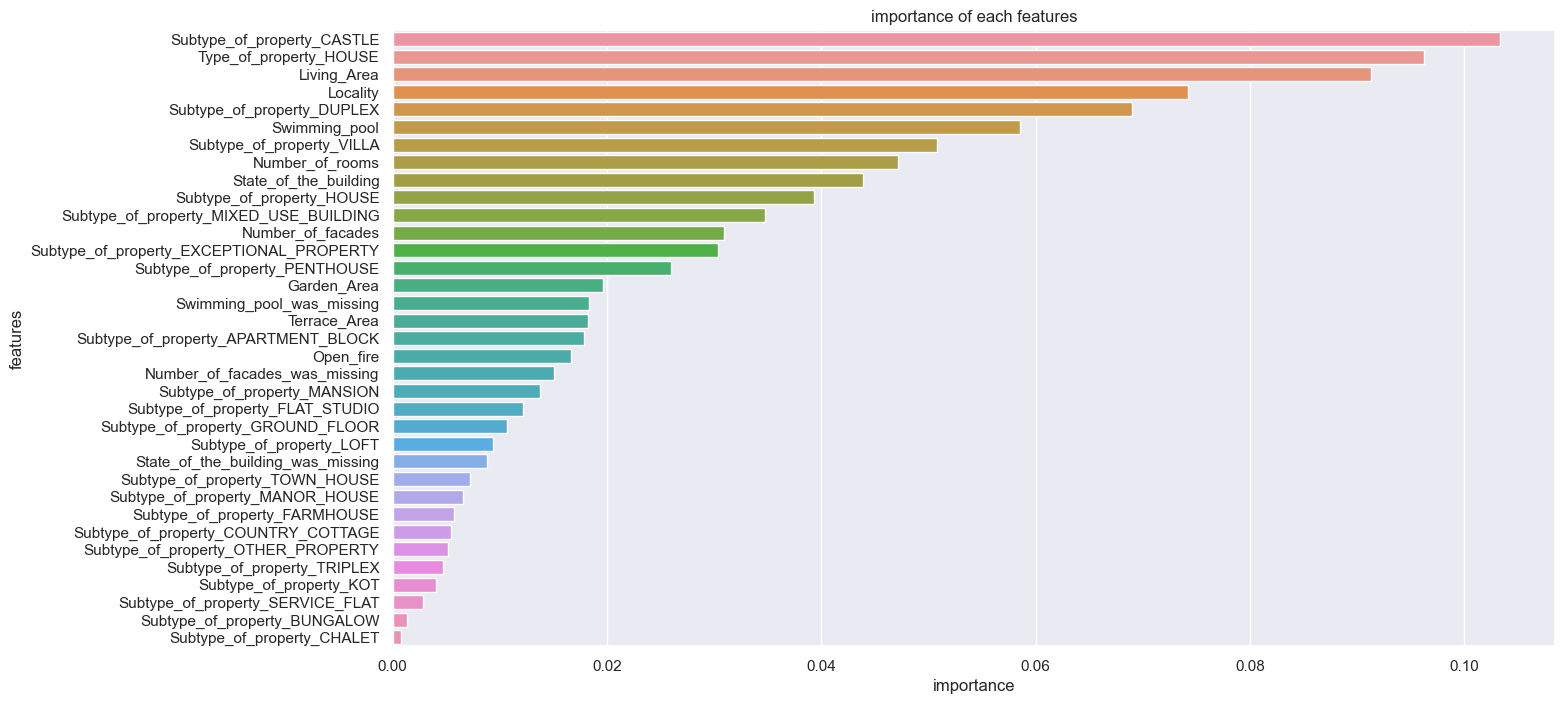

In [587]:
import numpy as np

# Sort feature importances in descending order
sorted_idx = np.argsort(model.feature_importances_)[::-1]

sns.set(rc={"figure.figsize": (15, 8)})
sns.barplot(
    x=model.feature_importances_[sorted_idx], y=X_train.columns[sorted_idx], orient="h"
)
plt.xlabel("importance")
plt.ylabel("features")
plt.title("importance of each features")
plt.show()

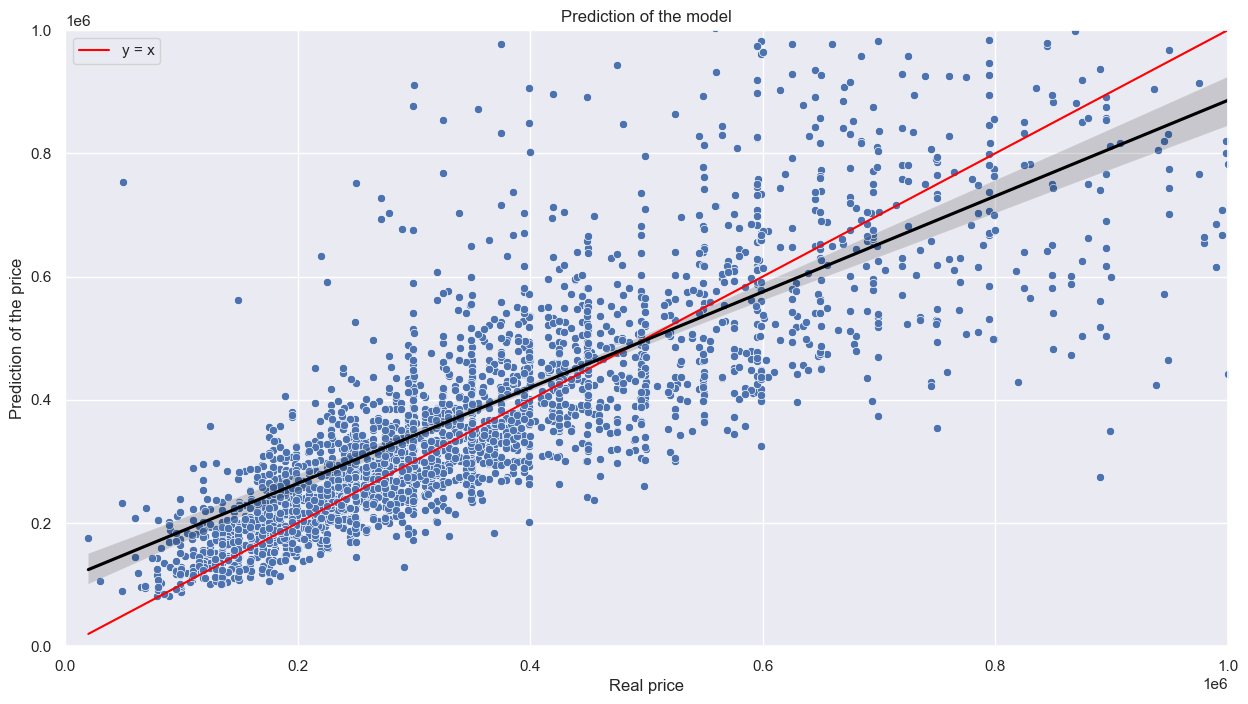

In [588]:
import matplotlib.pyplot as plt
import seaborn as sns

model = GradientBoostingRegressor(random_state=0, n_estimators=300, max_depth=5)
model.fit(X_train, y_train)
preds = model.predict(X_test)

plt.figure(figsize=(15, 8))
sns.scatterplot(x=y_test, y=preds)
sns.lineplot(x=y_test, y=y_test, color="red", label="y = x")

sns.regplot(
    x=y_test, y=preds, scatter_kws={"alpha": 0}, color="black", label="linear reg"
)
plt.xlim(0, 1000000)
plt.ylim(0, 1000000)

plt.title("Prediction of the model")
plt.xlabel("Real price")
plt.ylabel("Prediction of the price")

plt.show()

In [589]:
"""
from sklearn.model_selection import GridSearchCV

# Define the parameters to search through
param_grid = {'model__learning_rate': [ 0.07, 0.1],
              'model__max_depth': [5, 7],
              'model__min_child_weight': [4, 5],
              'model__subsample': [0.7, 0.8],
              'model__colsample_bytree': [0.6, 0.7]}

# Create an instance of GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5)

# Fit the GridSearchCV instance to the data
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters: {}".format(grid_search.best_params_))
#Best parameters: {'model__colsample_bytree': 0.7, 'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__min_child_weight': 4, 'model__subsample': 0.8}
"""

'\nfrom sklearn.model_selection import GridSearchCV\n\n# Define the parameters to search through\nparam_grid = {\'model__learning_rate\': [ 0.07, 0.1],\n              \'model__max_depth\': [5, 7],\n              \'model__min_child_weight\': [4, 5],\n              \'model__subsample\': [0.7, 0.8],\n              \'model__colsample_bytree\': [0.6, 0.7]}\n\n# Create an instance of GridSearchCV\ngrid_search = GridSearchCV(pipeline, param_grid, cv=5)\n\n# Fit the GridSearchCV instance to the data\ngrid_search.fit(X_train, y_train)\n\n# Print the best parameters\nprint("Best parameters: {}".format(grid_search.best_params_))\n#Best parameters: {\'model__colsample_bytree\': 0.7, \'model__learning_rate\': 0.1, \'model__max_depth\': 5, \'model__min_child_weight\': 4, \'model__subsample\': 0.8}\n'